In [21]:

%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from functools import wraps
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from matplotlib.colors import TABLEAU_COLORS, CSS4_COLORS, to_rgb
from tqdm.auto import tqdm
import seaborn as sns
from datetime import datetime, timedelta
import math
import pickle
import warnings
from scipy.signal import find_peaks, savgol_filter
from scipy.stats import mode, permutation_test, pearsonr, ttest_ind, ttest_1samp, wilcoxon, sem
from scipy.spatial import distance
from scipy import ndimage, interpolate
from pathlib import Path
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import functools
import cv2
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['axes.grid'] = False
import os
if Path('.').resolve().name != 'Arena':
    os.chdir('../Arena')
import config
from db_models import ORM, Experiment, Strike, Block, Video, Trial
from analysis.pose_utils import plot_regression, colorline, pixels2cm, fit_circle, put_text
from analysis.pose import DLCArenaPose, SpatialAnalyzer
from analysis.strikes.strikes import Loader, StrikeAnalyzer
from analysis.predictors.trajectories import TrajClassifier, TRAJ_DIR
plt.rcParams["xtick.bottom"] = True
plt.rcParams["xtick.direction"] = 'out'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
ANIMALS = ['PV91', 'PV163', 'PV95', 'PV99']
MOVEMENTS_TYPES = ['random_low_horizontal', 'circle']
orm = ORM()

def load_trajs_dataset():
    with orm.session() as s:
        orm_res = s.query(Strike, Trial, Block, Experiment).join(
            Trial, Trial.id == Strike.trial_id).join(
            Block, Block.id == Strike.block_id).join(
            Experiment, Experiment.id == Block.experiment_id).filter(
                Experiment.arena.in_(['reptilearn4']),
                Experiment.animal_id.in_(ANIMALS),
                Experiment.start_time > '2023-04-18',
                Block.movement_type.in_(MOVEMENTS_TYPES)
          ).all()
        
    strk_df_ = []
    trajs_ = {}
    for strk, tr, blk, exp in orm_res:
        if tr.bug_trajectory is None:
           continue
        
        try:
            strike_id = int(strk.id)
            ld = Loader(strike_id, 'front', is_load_pose=True, is_use_db=True, sec_before=3, sec_after=3)
            pose_df = ld.frames_df.copy()
            pose_df['total_sec'] = (pose_df[('time', '')] - pose_df.loc[ld.strike_frame_id, ('time', '')]).dt.total_seconds()
            pose_df = pd.concat([pose_df['time'], pose_df['total_sec'], pose_df['nose'][['x', 'y', 'prob']], pose_df['angle']], axis=1)
            pose_df['strike_id'] = strike_id
            trajs_[strike_id] = pose_df
            
            strk_df_.append({'id': strike_id, 'animal_id': exp.animal_id, 'block_id': blk.id, 'trial_id': tr.id, 'movement_type': blk.movement_type,
                             'time': strk.time, 'block_speed': blk.bug_speed, 'calc_speed': strk.calc_speed, 'is_hit': strk.is_hit, 'bug_type': strk.bug_type})
        except Exception as exc:
            print(f'Error in strike id: {strike_id}; {exc}')
            continue
      
    strk_df_ = pd.DataFrame(strk_df_).set_index('id')
    # add the frame_strike_id column to indicate which strike_id corresponds to each frame
    for strike_id, tf in trajs_.items():
        tf['frame_strike_id'] = None
        trial_id = strk_df_.loc[strike_id, 'trial_id']
        for strike_id_, row in strk_df_.query(f'trial_id=={trial_id}').iterrows():
            if tf.time.iloc[0] <= row.time <= tf.time.iloc[-1]:
                i = (tf.time - row.time).dt.total_seconds().abs().idxmin()
                tf.loc[i, 'frame_strike_id'] = strike_id_
    
    return strk_df_, trajs_


strk_df, trajs = load_trajs_dataset()

In [ ]:
with open('/media/sil2/Data/regev/datasets/trajs/trajs_2s_after.pkl', 'wb') as f:
    pickle.dump({'strk_df': strk_df, 'trajs': trajs}, f)

### Paper Figure

 80%|████████  | 4/5 [00:14<00:03,  3.60s/it]

Notice! Shuffling randomly the target values


100%|██████████| 5/5 [00:17<00:00,  3.58s/it]


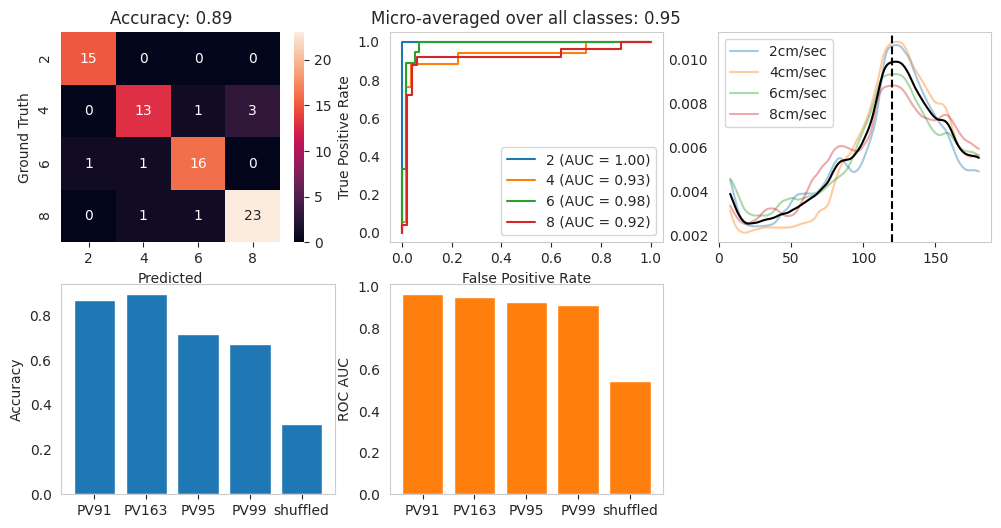

In [112]:
chosen_animal = 'PV163'
chosen_movement = 'random_low_horizontal'
animals = ['PV91', 'PV163', 'PV95', 'PV99', 'all']

# model_paths = []
model_paths = [
    'traj_classifier_PV91_random_low_horizontal/20240825_140000',
    'traj_classifier_PV163_random_low_horizontal/20240825_124807',
    'traj_classifier_PV95_random_low_horizontal/20240825_153605',
    'traj_classifier_PV99_random_low_horizontal/20240825_140603',
    'traj_classifier_PV91_random_low_horizontal/20240825_145143'  # shuffled
]
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
# for animal_id in animals:
for model_path in tqdm(model_paths):
    model_path = f'{TRAJ_DIR}/{model_path}'
    tj = TrajClassifier(model_path=model_path, is_debug=False)
    animal_id = tj.animal_id if not tj.is_shuffled_target else 'shuffled'
    # tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(-2, 180), is_resample=False,
    #                 animal_id=animal_id, movement_type=chosen_movement, is_hit=False, lstm_layers=4, dropout_prob=0.3, lstm_hidden_dim=50,)
    # tj.train(is_plot=False)
    # model_paths.append(tj.model_path)
    if animal_id == chosen_animal:
        tj.all_data_evaluation(axes=axes[0, :])
    
    y_true, y_pred, y_score, attns = tj.get_data_for_evaluation()
    y_true_binary = label_binarize(y_true, classes=np.arange(len(tj.targets)))
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true_binary, y_score, average="weighted")
    axes[1, 0].bar(animal_id, acc, color='tab:blue')
    axes[1, 1].bar(animal_id, auc, color='tab:orange')

for ax in axes.flatten():
    ax.grid(False)

axes[1, 2].axis('off')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 1].set_ylabel('ROC AUC')
fig.savefig(f'{TRAJ_DIR}/traj_model_plots.pdf')

### PV91, random_low_horizontal

Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}
Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


FOLD-#5 (102,25)  val_loss=2.18 (best=0.53): 100%|██████████| 150/150 [00:58<00:00,  2.58it/s]


Chosen model is of Fold#3
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240825_140000
Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}


100%|██████████| 127/127 [00:02<00:00, 61.44it/s]


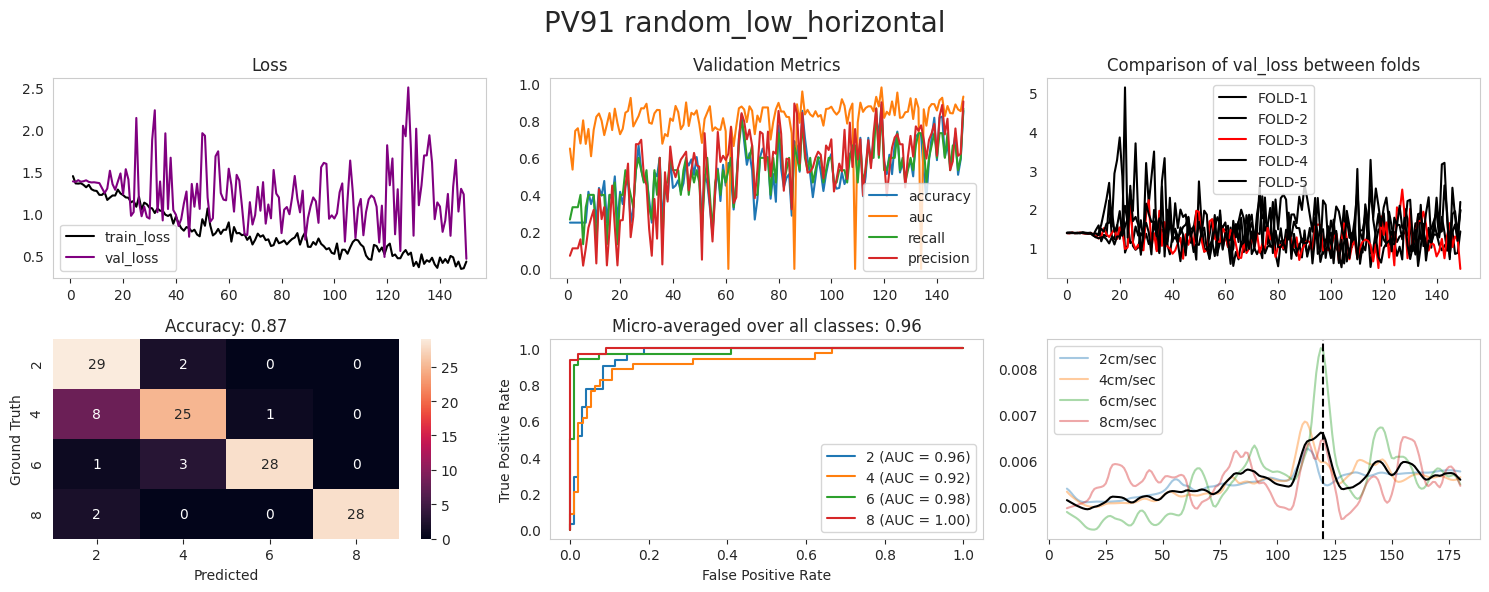

Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}


100%|██████████| 127/127 [00:02<00:00, 62.34it/s]


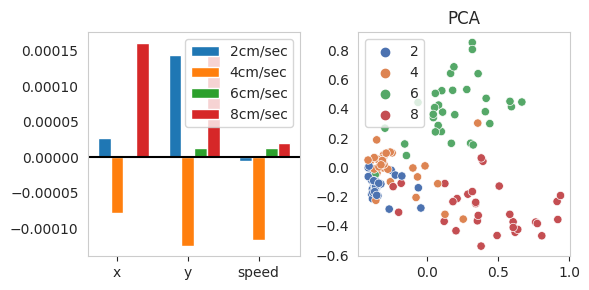

In [100]:
tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(-2, 180), is_resample=False,
                    animal_id='PV91', movement_type='random_low_horizontal', is_hit=False, lstm_layers=4, dropout_prob=0.3, lstm_hidden_dim=150,
                    feature_names=['x', 'y', 'speed'])
tj.train(is_plot=True)
tj.check_hidden_states();

### PV95, random_low_horizontal

Traj classes count: {2: 31, 4: 30, 6: 30, 8: 32}
Start train for model traj_classifier_PV95_random_low_horizontal. Train will be running on cuda:0 device


FOLD-#5 (99,24)  val_loss=1.38 (best=0.96): 100%|██████████| 150/150 [01:18<00:00,  1.90it/s]


Chosen model is of Fold#3
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV95_random_low_horizontal/20240825_153605
Traj classes count: {2: 31, 4: 30, 6: 30, 8: 32}


100%|██████████| 123/123 [00:02<00:00, 43.08it/s]


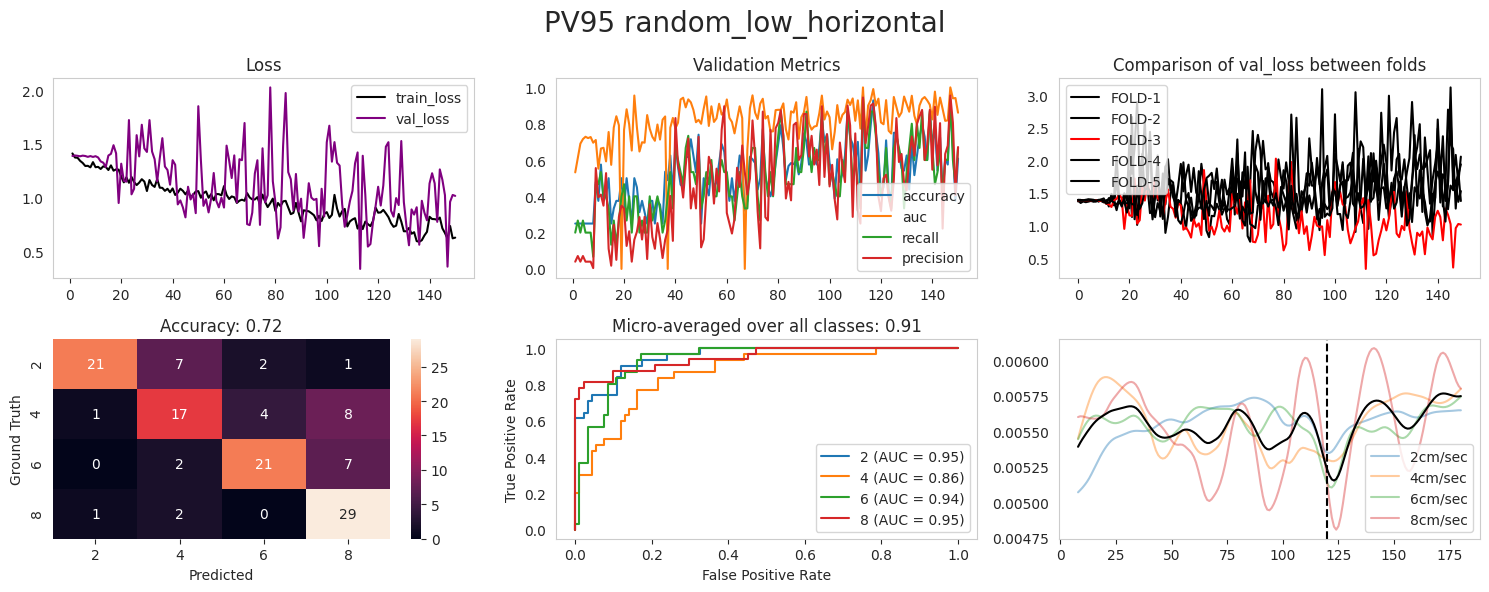

Traj classes count: {2: 31, 4: 30, 6: 30, 8: 32}


100%|██████████| 123/123 [00:02<00:00, 43.78it/s]


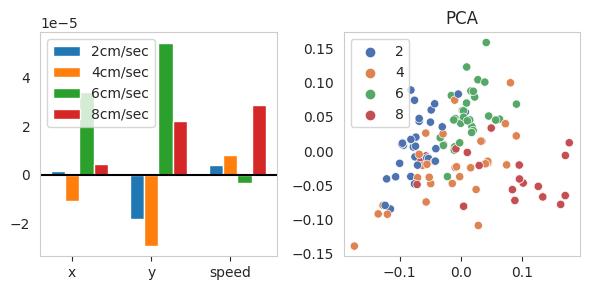

In [109]:
tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(-2, 180), is_resample=False,
                    animal_id='PV95', movement_type='random_low_horizontal', is_hit=False, lstm_layers=6, dropout_prob=0.1, lstm_hidden_dim=100,
                    feature_names=['x', 'y', 'speed'])
tj.train(is_plot=True)
tj.check_hidden_states();

In [110]:
df = pd.read_csv('/media/sil2/Data/regev/datasets/trajs/hyperparameters_results_2024-08-22T15:46:41.191693.csv', index_col=0)
df.query('metric=="overall_accuracy"').sort_values(by='value', ascending=False)

,metric,value,animal_id,movement_type,dropout_prob,lstm_hidden_dim,lstm_layers
111,overall_accuracy,0.780488,PV95,random_low_horizontal,0.3,150,4
34,overall_accuracy,0.756098,PV95,random_low_horizontal,0.1,100,6
27,overall_accuracy,0.747967,PV95,random_low_horizontal,0.1,100,4
13,overall_accuracy,0.747967,PV95,random_low_horizontal,0.1,50,6
6,overall_accuracy,0.723577,PV95,random_low_horizontal,0.1,50,4
174,overall_accuracy,0.699187,PV95,random_low_horizontal,0.4,150,4
48,overall_accuracy,0.699187,PV95,random_low_horizontal,0.1,150,4
69,overall_accuracy,0.699187,PV95,random_low_horizontal,0.3,50,4
139,overall_accuracy,0.691057,PV95,random_low_horizontal,0.4,50,6
76,overall_accuracy,0.691057,PV95,random_low_horizontal,0.3,50,6


### PV163, random_low_horiontal

Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}
setting kfolds to 4
Start train for model traj_classifier_PV163_random_low_horizontal. Train will be running on cuda:0 device


FOLD-#4 (57,18)  val_loss=1.74 (best=0.81): 100%|██████████| 150/150 [00:31<00:00,  4.78it/s]


Chosen model is of Fold#4
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV163_random_low_horizontal/20240825_124807
Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}


100%|██████████| 75/75 [00:01<00:00, 62.54it/s]


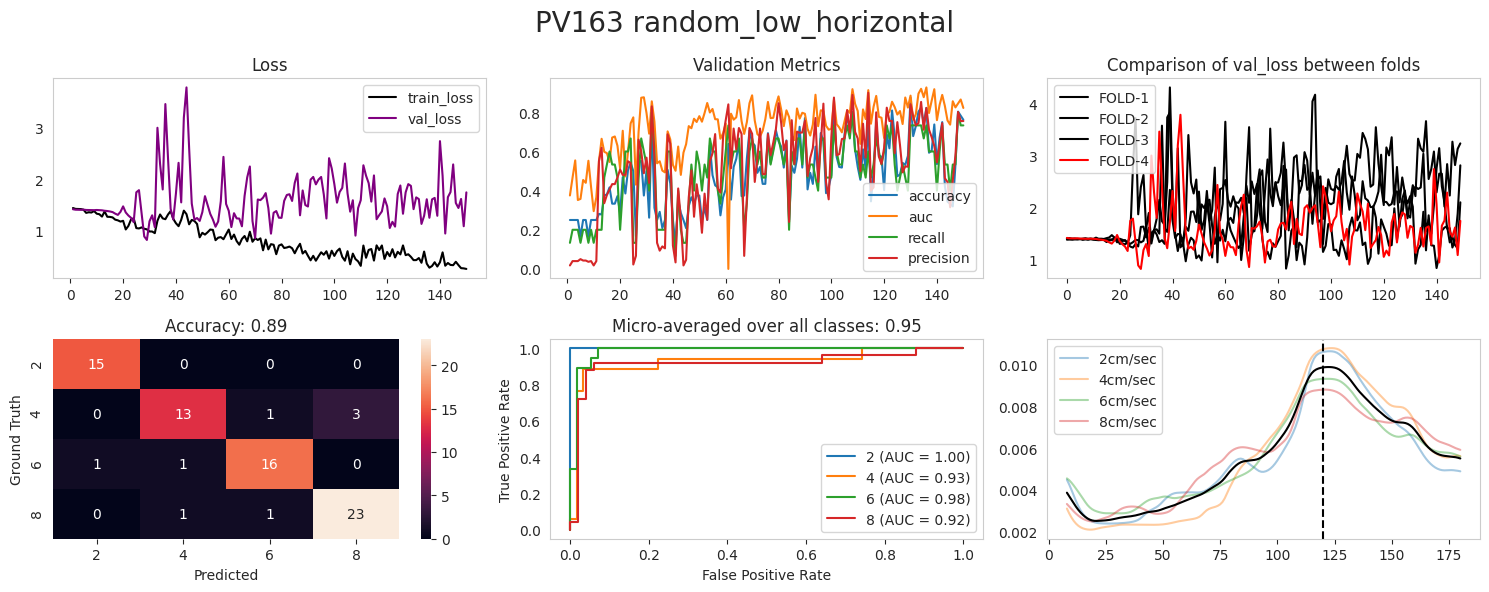

Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}


100%|██████████| 75/75 [00:01<00:00, 63.92it/s]


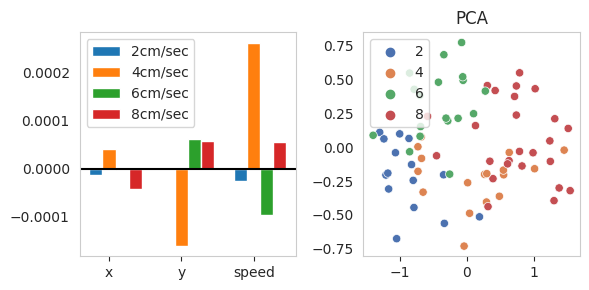

In [95]:
tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(-2, 180), is_resample=False,
                    animal_id='PV163', movement_type='random_low_horizontal', is_hit=False, lstm_layers=4, dropout_prob=0.3, lstm_hidden_dim=150,
                    feature_names=['x', 'y', 'speed'])
tj.train(is_plot=True)
tj.check_hidden_states();

In [94]:
df = pd.read_csv('/media/sil2/Data/regev/datasets/trajs/hyperparameters_results_PV163_2024-08-23T18:22:23.933332.csv', index_col=0)
df.query('metric=="overall_accuracy"').sort_values(by='value', ascending=False)

,metric,value,animal_id,movement_type,dropout_prob,lstm_hidden_dim,lstm_layers
111,overall_accuracy,0.893333,PV163,random_low_horizontal,0.3,150,4
62,overall_accuracy,0.866667,PV163,random_low_horizontal,0.1,150,8
6,overall_accuracy,0.840000,PV163,random_low_horizontal,0.1,50,4
48,overall_accuracy,0.826667,PV163,random_low_horizontal,0.1,150,4
153,overall_accuracy,0.813333,PV163,random_low_horizontal,0.4,100,4
202,overall_accuracy,0.813333,PV163,random_low_horizontal,0.6,50,6
174,overall_accuracy,0.813333,PV163,random_low_horizontal,0.4,150,4
90,overall_accuracy,0.800000,PV163,random_low_horizontal,0.3,100,4
20,overall_accuracy,0.800000,PV163,random_low_horizontal,0.1,50,8
209,overall_accuracy,0.800000,PV163,random_low_horizontal,0.6,50,8


### PV99, random_low_horiontal

Traj classes count: {2: 30, 4: 28, 6: 33, 8: 33}
Start train for model traj_classifier_PV99_random_low_horizontal. Train will be running on cuda:0 device


FOLD-#5 (100,24)  val_loss=1.20 (best=1.04): 100%|██████████| 150/150 [00:58<00:00,  2.58it/s]


Chosen model is of Fold#4
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV99_random_low_horizontal/20240825_140603
Traj classes count: {2: 30, 4: 28, 6: 33, 8: 33}


100%|██████████| 124/124 [00:02<00:00, 61.78it/s]


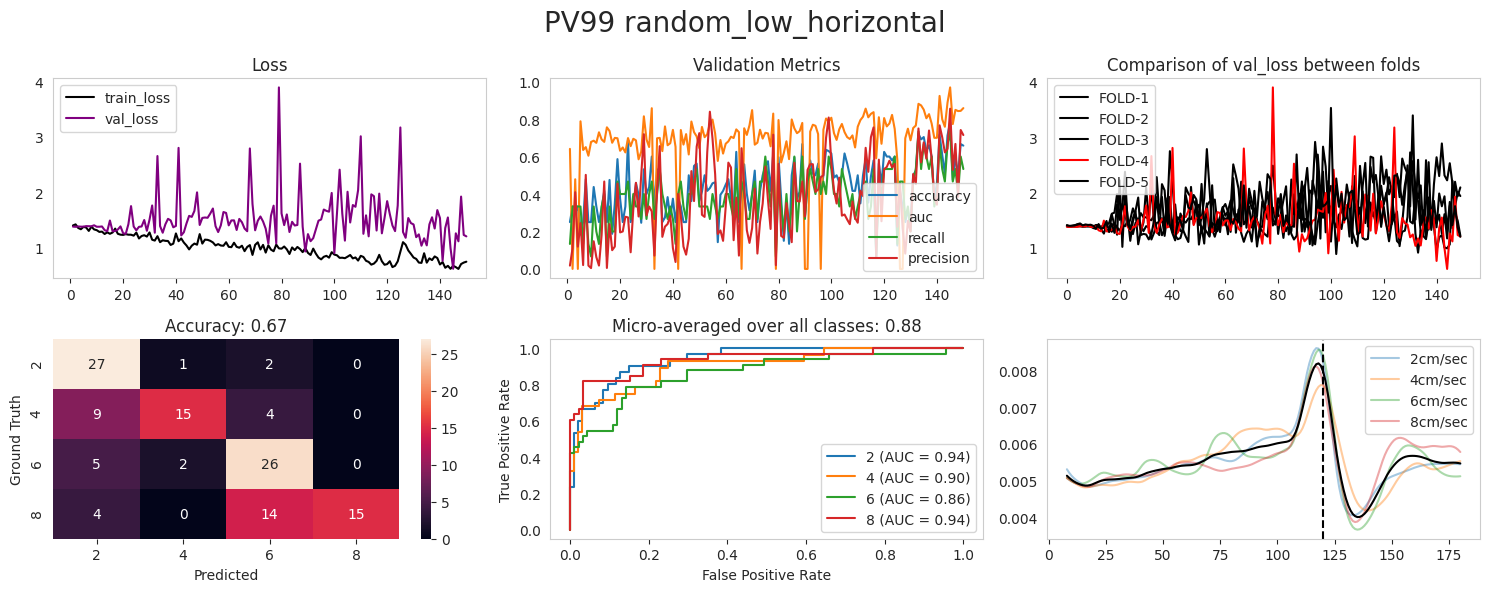

Traj classes count: {2: 30, 4: 28, 6: 33, 8: 33}


100%|██████████| 124/124 [00:01<00:00, 62.94it/s]


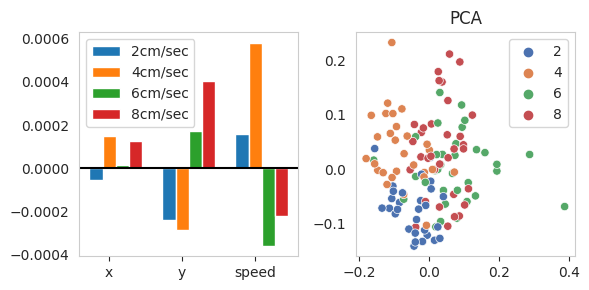

In [101]:
tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(-2, 180), is_resample=False,
                    animal_id='PV99', movement_type='random_low_horizontal', is_hit=False, lstm_layers=4, dropout_prob=0.3, lstm_hidden_dim=150,
                    feature_names=['x', 'y', 'speed'])
tj.train(is_plot=True)
tj.check_hidden_states();

In [96]:
df = pd.read_csv('/media/sil2/Data/regev/datasets/trajs/hyperparameters_results_PV99_2024-08-23T19:29:30.503671.csv', index_col=0)
df.query('metric=="overall_accuracy"').sort_values(by='value', ascending=False)

,metric,value,animal_id,movement_type,dropout_prob,lstm_hidden_dim,lstm_layers
48,overall_accuracy,0.741935,PV99,random_low_horizontal,0.1,150,4
41,overall_accuracy,0.733871,PV99,random_low_horizontal,0.1,100,8
174,overall_accuracy,0.725806,PV99,random_low_horizontal,0.4,150,4
111,overall_accuracy,0.701613,PV99,random_low_horizontal,0.3,150,4
90,overall_accuracy,0.693548,PV99,random_low_horizontal,0.3,100,4
13,overall_accuracy,0.693548,PV99,random_low_horizontal,0.1,50,6
209,overall_accuracy,0.661290,PV99,random_low_horizontal,0.6,50,8
146,overall_accuracy,0.637097,PV99,random_low_horizontal,0.4,50,8
132,overall_accuracy,0.629032,PV99,random_low_horizontal,0.4,50,4
76,overall_accuracy,0.612903,PV99,random_low_horizontal,0.3,50,6


### Shuffled, random_low_horiontal

Notice! Shuffling randomly the target values
Traj classes count: {2: 34, 4: 32, 6: 30, 8: 31}
Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


FOLD-#5 (102,25)  val_loss=2.20 (best=1.33): 100%|██████████| 150/150 [00:58<00:00,  2.56it/s]


Chosen model is of Fold#1
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240825_145143
Notice! Shuffling randomly the target values
Traj classes count: {2: 43, 4: 31, 6: 24, 8: 29}


100%|██████████| 127/127 [00:02<00:00, 62.22it/s]


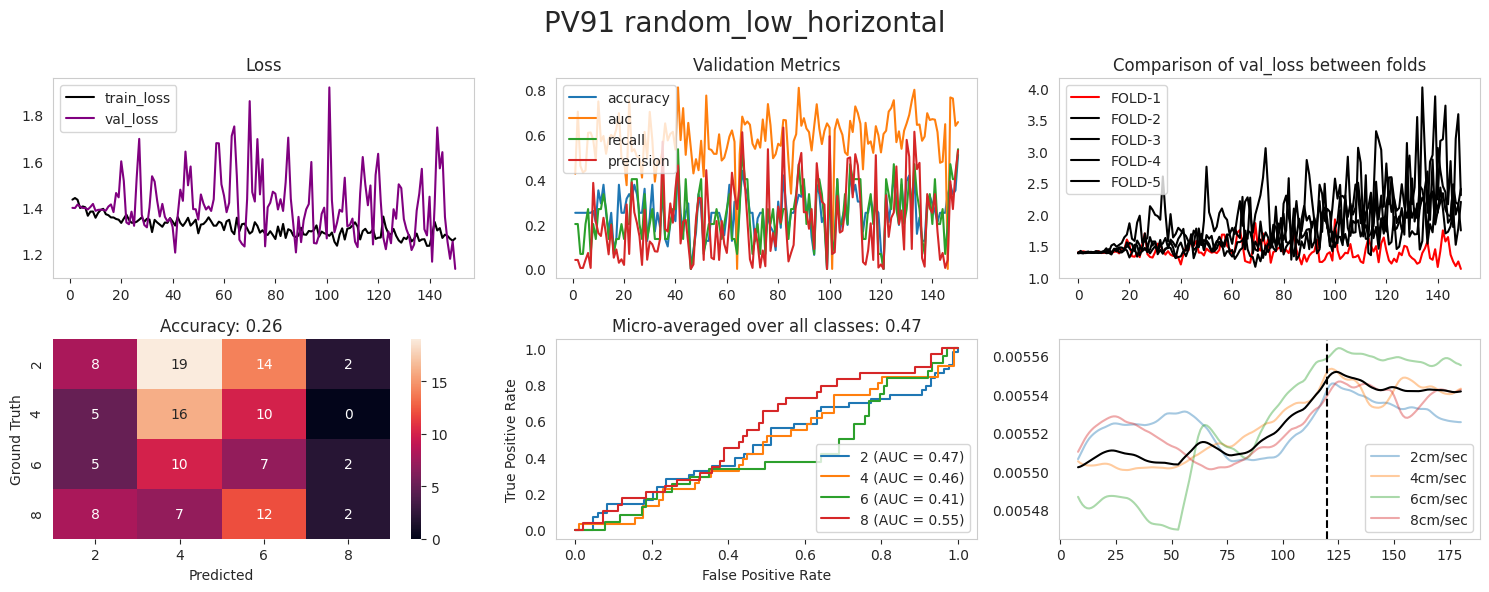

Notice! Shuffling randomly the target values
Traj classes count: {2: 26, 4: 36, 6: 43, 8: 22}


100%|██████████| 127/127 [00:02<00:00, 63.35it/s]


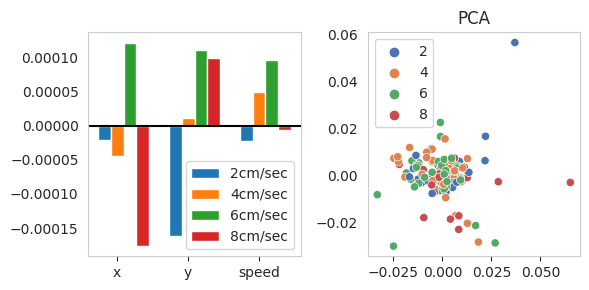

In [102]:
tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(-2, 180), is_resample=False, is_shuffled_target=True,
                    animal_id='PV91', movement_type='random_low_horizontal', is_hit=False, lstm_layers=4, dropout_prob=0.3, lstm_hidden_dim=150,
                    feature_names=['x', 'y', 'speed'])
tj.train(is_plot=True)
tj.check_hidden_states();

### PV163, circle

Resampling trajectories to 28 samples from each block_speed class
Traj classes count: {2: 28, 4: 28, 6: 28, 8: 28}
Start train for model traj_classifier_PV91_circle. Train will be running on cuda:0 device


FOLD-#5 (90,22)  val_loss=2.05 (best=0.93): 100%|██████████| 150/150 [00:58<00:00,  2.58it/s]


Chosen model is of Fold#3
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_circle/20240825_150409
Resampling trajectories to 28 samples from each block_speed class
Traj classes count: {2: 28, 4: 28, 6: 28, 8: 28}


100%|██████████| 112/112 [00:01<00:00, 62.03it/s]


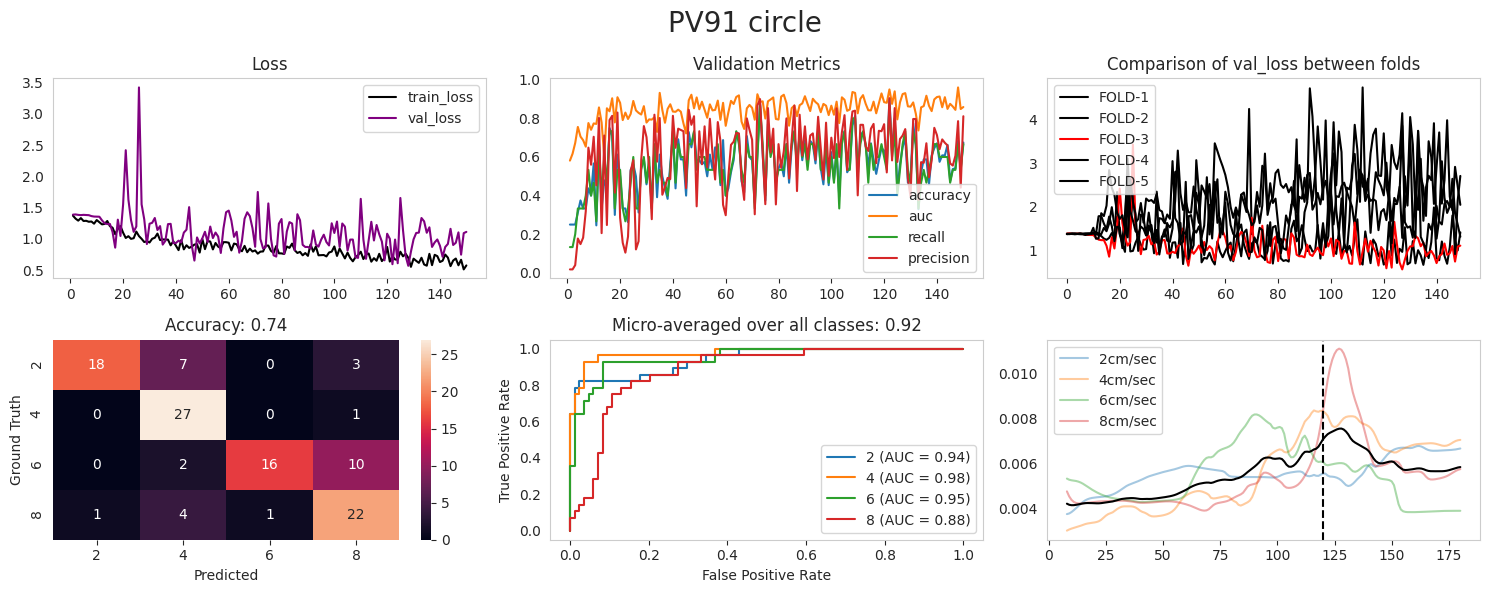

Resampling trajectories to 28 samples from each block_speed class
Traj classes count: {2: 28, 4: 28, 6: 28, 8: 28}


100%|██████████| 112/112 [00:01<00:00, 61.83it/s]


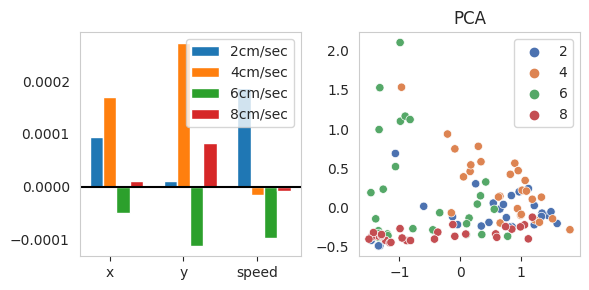

In [104]:
tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(-2, 180), is_resample=True,
                    animal_id='PV91', movement_type='circle', is_hit=False, lstm_layers=4, dropout_prob=0.3, lstm_hidden_dim=150,
                    feature_names=['x', 'y', 'speed'])
tj.train(is_plot=True)
tj.check_hidden_states();

### All animals, Circle

In [ ]:
tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(-2, 150), is_resample=True,
                    feature_names=['x', 'y', 'speed_x', 'speed_y'],
                    animal_id='all', movement_type='circle', is_hit=False, lstm_layers=6, dropout_prob=0.5)
tj.train(is_plot=True)
tj.check_hidden_states()

### All animals, random_low_horizontal

Traj classes count: {2: 107, 4: 109, 6: 113, 8: 120}
Start train for model traj_classifier_all_random_low_horizontal. Train will be running on cuda:0 device


FOLD-#5 (360,89)  val_loss=1.14 (best=1.05): 100%|██████████| 150/150 [05:26<00:00,  2.17s/it]


Chosen model is of Fold#1
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_all_random_low_horizontal/20240822_142619
Traj classes count: {2: 107, 4: 109, 6: 113, 8: 120}


100%|██████████| 449/449 [00:10<00:00, 42.20it/s]


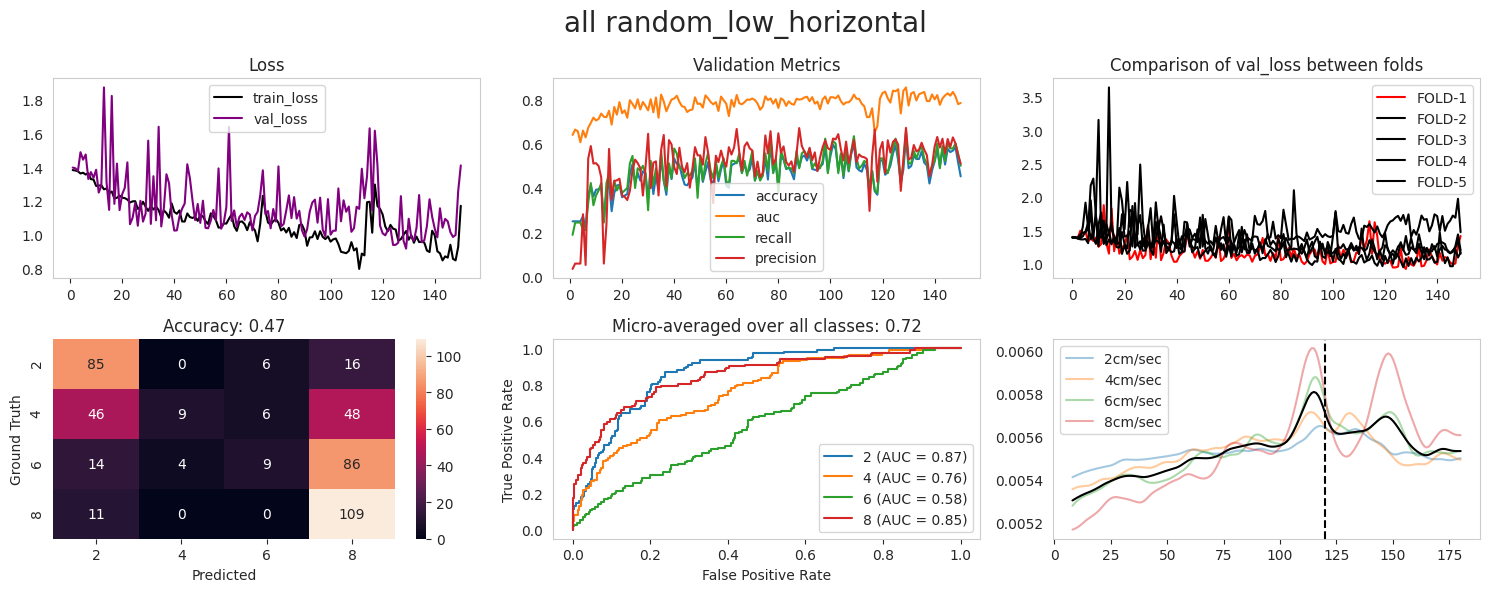

Traj classes count: {2: 107, 4: 109, 6: 113, 8: 120}


100%|██████████| 449/449 [00:10<00:00, 42.25it/s]


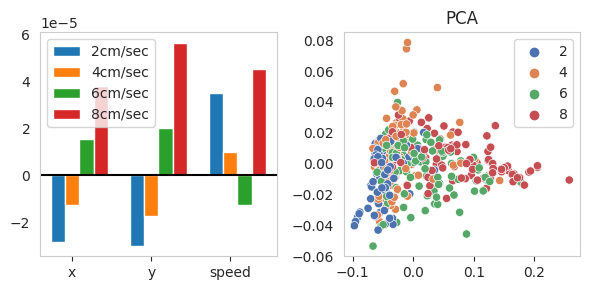

In [89]:
tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(-2, 180), is_resample=False,
                    animal_id='all', movement_type='random_low_horizontal', is_hit=False, lstm_layers=6, dropout_prob=0.4, lstm_hidden_dim=50,
                    feature_names=['x', 'y', 'speed'])
tj.train(is_plot=True)
tj.check_hidden_states();

In [ ]:
attns = {}
for model_path in tqdm(model_paths):
    tj = TrajClassifier(model_path=model_path)
    tj.model.eval()
    dataset = tj.get_dataset()
    y_true, y_pred, y_score = [], [], []
    attns = {}
    for x, y in dataset:
        outputs, attention_weights = tj.model(x.to(tj.device).unsqueeze(0), is_attn=True)
        attns.setdefault(tj.targets[y.item()], []).append(attention_weights.detach().cpu().numpy())
        label, prob = tj.predict_proba(outputs, is_all_probs=True)
        y_true.append(y.item())
        y_pred.append(label.item())
        y_score.append(prob.detach().cpu().numpy())

    for bug_speed in tj.targets:
        att = attns[bug_speed]
        att = np.vstack(att).mean(axis=0)
        att[:5] = np.nan
        attns.setdefault(bug_speed, []).append(att)
        
for bug_speed, a in attns.items():
    a_ = np.vstack(a).mean(axis=0)
    plt.plot(a_, label=str(bug_speed))
plt.legend()

model traj_classifier_PV91_random_low_horizontal load from: /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240821_133922
Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}


100%|██████████| 127/127 [00:02<00:00, 44.11it/s]


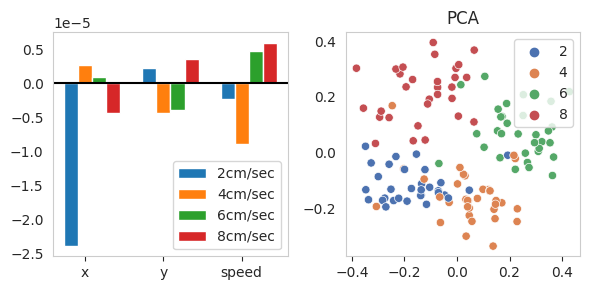

In [88]:
tj = TrajClassifier(model_path='/media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240821_133922')
# tj.all_data_evaluation()
tj.check_hidden_states()

Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}


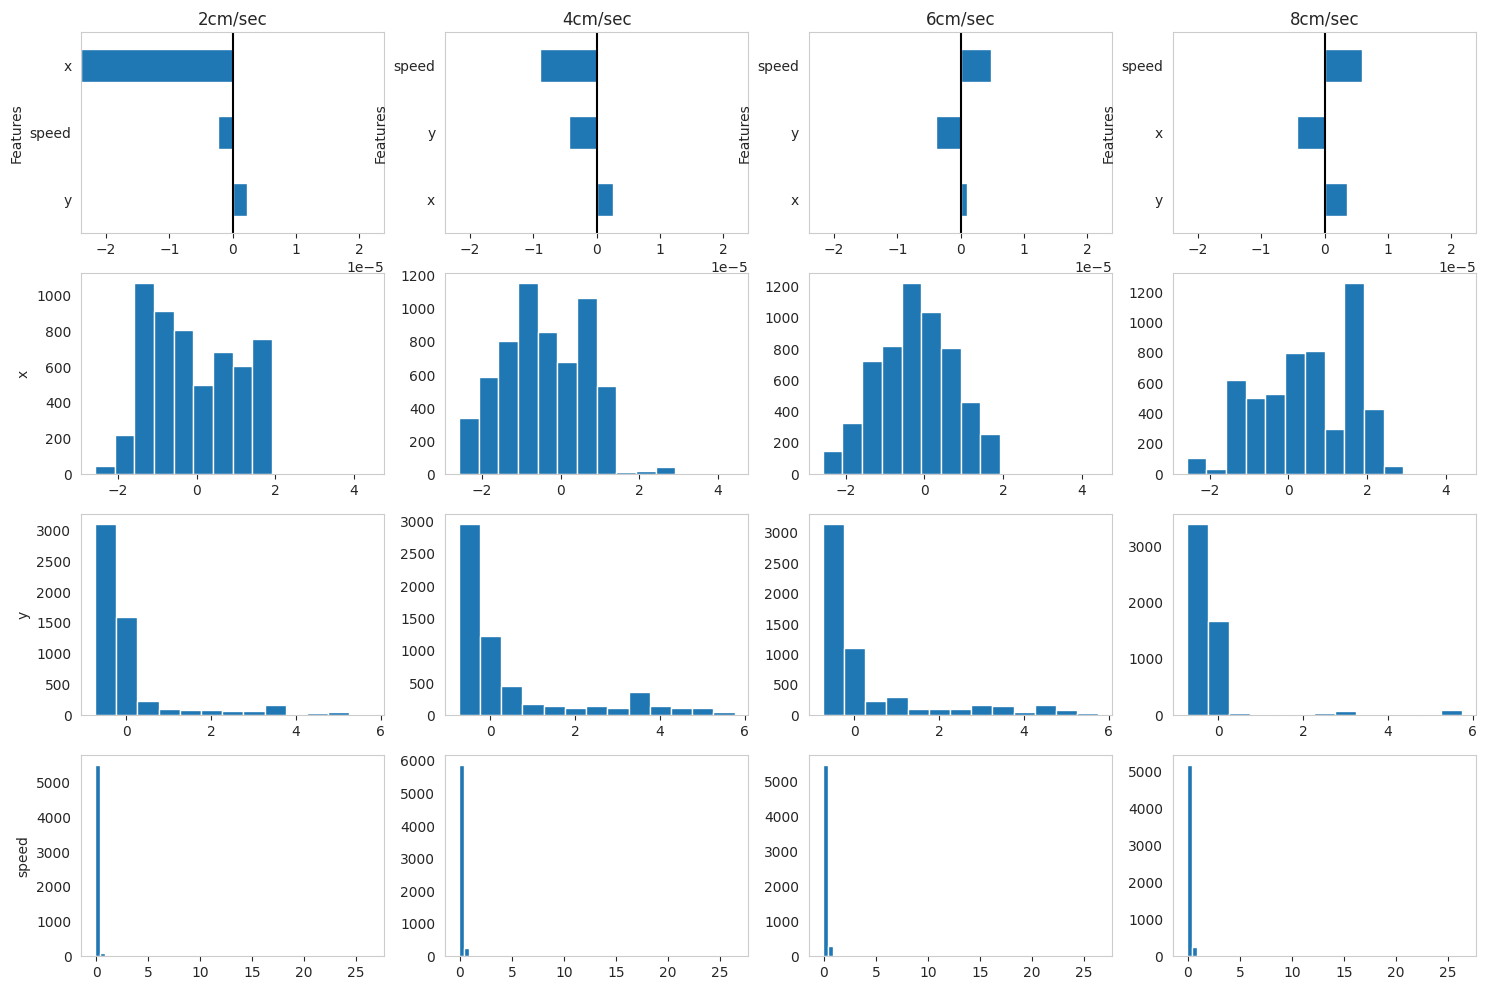

In [85]:
import torch
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)

dataset = tj.get_dataset()
torch.backends.cudnn.enabled=False
tj.model.eval()
ig = IntegratedGradients(tj.model)

fig, axes = plt.subplots(1+len(tj.feature_names), len(tj.targets), figsize=(18, 3*(1+len(tj.feature_names))))

res = {}
aggregated_attributions, all_data = {}, {}
for x, y in dataset:
    input_ = x.to(tj.device).unsqueeze(0)
    baseline = torch.zeros(input_.shape).to(tj.device)
    attr, delta = ig.attribute(input_, baseline, target=y.item(), return_convergence_delta=True)
    aggregated_attributions.setdefault(tj.targets[y.item()], []).append(attr)
    all_data.setdefault(tj.targets[y.item()], []).append(input_.cpu().numpy().squeeze())

all_data_limits = {k: [0, 0] for k in tj.feature_names}
for target, x in aggregated_attributions.items():
    x = torch.cat(x, dim=0)
    importance = np.mean(x.cpu().detach().numpy(), axis=0)
    imp = pd.Series(importance[-1])
    idx = imp.abs().sort_values().index.tolist()
    imp = imp.reindex(idx)
    imp.index = [tj.feature_names[i] for i in imp.index]
    max_x = np.abs(importance[-1]).max()
    res[target] = (imp, max_x)
    
    all_data[target] = np.vstack(all_data[target])
    for k, fn in enumerate(tj.feature_names):
        if all_data_limits[fn][1] < max(all_data[target][:, k]):
            all_data_limits[fn][1] = max(all_data[target][:, k])
        if all_data_limits[fn][0] > min(all_data[target][:, k]):
            all_data_limits[fn][0] = min(all_data[target][:, k])

max_x = max([x[1] for x in res.values()])
for i, target in enumerate(sorted(list(res.keys()))):
    imp, _ = res[target]
    imp.plot.barh(ax=axes[0, i])
    axes[0, i].set_xlim([-max_x, max_x])
    axes[0, i].set_ylabel('Features')
    axes[0, i].set_title(f'{target}cm/sec')
    axes[0, i].axvline(0, color='black')
    
    for j, feature_name in enumerate(tj.feature_names):
        bins = np.arange(*all_data_limits[feature_name], 0.5)
        axes[j+1, i].hist(all_data[target][:, j], bins=bins)
        if i == 0:
            axes[j+1, i].set_ylabel(feature_name)

In [80]:
imp.values

array([ 3.57711805e-06, -4.39550315e-06,  5.98249033e-06])

In [ ]:
y.item()

In [ ]:
tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(-2, 150), is_resample=False, is_shuffled_target=True,
                    animal_id='PV91', movement_type='random_low_horizontal', is_hit=False, lstm_layers=4, dropout_prob=0.3, lstm_hidden_dim=50)
tj.train(is_plot=True);

### Target = is_hit

In [ ]:
tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(-2, 150), is_resample=False,
                    animal_id='all', movement_type='random_low_horizontal', is_hit=False, lstm_layers=4, dropout_prob=0.3, lstm_hidden_dim=50,
                    target_name='is_hit', targets=[0, 1])
tj.train(is_plot=True);

### Target = bug type

In [ ]:
tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(-2, 150), is_resample=True,
                    animal_id='all', movement_type='random_low_horizontal', is_hit=False, lstm_layers=4, dropout_prob=0.3, lstm_hidden_dim=50,
                    target_name='bug_type', targets=['worm', 'cockroach', 'red_beetle', 'green_beetle'])
tj.train(is_plot=True);

### Feature Importance

In [ ]:
# tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(-2, 150), is_resample=False,
#                     feature_names=['x', 'y', 'prob', 'speed', 'angle'], 
#                     animal_id='all', movement_type='random_low_horizontal', is_hit=False, lstm_layers=4, dropout_prob=0.3, lstm_hidden_dim=50)
# tj.train(is_plot=True)

tj = TrajClassifier(model_path='/media/sil2/Data/regev/datasets/trajs/traj_classifier_all_random_low_horizontal/20240722_105828')
tj.check_hidden_states()

### Find optimal span

In [ ]:
res_df = []

for t_start in np.arange(-3, 2, 0.5):
    for span_sec in [60, 90, 120, 150, 180, 210]:
        if (t_start + (span_sec / 60)) > 3:
            continue
        print(f'Start training with t_start: {t_start}, span_sec: {span_sec}')
        try:
            tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(t_start, span_sec), is_resample=False,
                    feature_names=['x', 'y', 'speed_x', 'speed_y'],
                    animal_id='all', movement_type='random_low_horizontal', is_hit=False, lstm_layers=4, dropout_prob=0.3, lstm_hidden_dim=50)
            tj.train(is_plot=False)
            best_i = np.argmin([x['score'] for x in tj.history])
            best_epoch = np.argmin(tj.history[best_i]['metrics']['val_loss'])
            for metric, l in tj.history[best_i]['metrics'].items():
                res_df.append({'t_start': t_start, 'span_sec': span_sec, 'metric': metric, 'value': l[best_epoch]})
        except Exception as exc:
            print(f'Error in t_start: {t_start}, span_sec: {span_sec}; {exc}')

res_df = pd.DataFrame(res_df)
filename = f'{TRAJ_DIR}/optimal_span_{datetime.now().isoformat()}.csv'
res_df.to_csv(filename)

In [ ]:
trajs[103]

In [5]:
with open('/media/sil2/Data/regev/datasets/trajs/trajs_2s_after.pkl', 'rb') as f:
    d_ = pickle.load(f)
    strk_df, trajs = d_['strk_df'], d_['trajs']

In [7]:
strk_df.animal_id.value_counts()

PV91     369
PV99     202
PV163    186
PV95     123
Name: animal_id, dtype: int64

In [ ]:
res = {}
for strike_id, row in strk_df.query('movement_type=="circle"').iterrows():
    res.setdefault(row.block_speed, []).extend(trajs[strike_id].prob.values.tolist())

res = dict(sorted(res.items(), key=lambda kv: kv[0]))
fig, axes = plt.subplots(1, len(res), figsize=(20, 4))
for i, (block_speed, l) in enumerate(res.items()):
    axes[i].hist(l, bins=np.arange(0, 1, 0.01))
    axes[i].set_title(str(block_speed))
    axes[i].set_ylim([0, 160])

### plot trajectory examples

In [ ]:
def plot_trajs_examples(animal_id, movement_type, n_samples=18):
    cols = 6
    rows = int(np.ceil(n_samples/cols))
    with open('/media/sil2/Data/regev/datasets/trajs/trajs_2s_after.pkl', 'rb') as f:
        d_ = pickle.load(f)
        strk_df, trajs = d_['strk_df'], d_['trajs']
    g = strk_df.query(f'animal_id=="{animal_id}" and movement_type=="{movement_type}"').groupby('block_speed').apply(
        lambda x: x.sample(n_samples, random_state=0, replace=False))
    block_speeds = g.index.get_level_values(0).unique().tolist() 

    fig = plt.figure(figsize=(25, len(block_speeds)*rows*3), constrained_layout=True)
    subfigs = fig.subfigures(len(block_speeds), 1, hspace=0.1)

    for k, block_speed in enumerate(block_speeds):
        axes = subfigs[k].subplots(rows, cols)  
        axes = axes.flatten()
        for i, strike_id in enumerate(g.loc[block_speed].index):
            t = trajs[strike_id]
            total_dist = np.sqrt((t.x.diff() ** 2) + (t.y.diff() ** 2)).sum()
            axes[i].plot(t.x, t.y)
            axes[i].set_title(f'Strike {strike_id} (hit:{g.loc[block_speed].loc[strike_id].is_hit},dist={total_dist:.1f})')
            axes[i].set_xlim([0, 55])
            axes[i].set_ylim([-4, 50])
        subfigs[k].suptitle(f'Block Speed: {block_speed}')
    fig.savefig(f'{TRAJ_DIR}/trajs_examples_{animal_id}_{movement_type}.pdf', bbox_inches='tight')


plot_trajs_examples('PV163', 'random_low_horizontal', n_samples=12)

In [ ]:
tj = TrajClassifier(model_path='/media/sil2/Data/regev/datasets/trajs/traj_classifier_all_random_low_horizontal/20240714_123934')
tj.all_data_evaluation()

In [ ]:
res = []
for sub_sect in [(-3, 180), (-2.5, 150), (-2, 120), (-1.5, 90), (-1, 60), (-0.5, 30), (-0.2, 12), (-0.1, 6)]:
    try:
        tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=sub_sect, is_resample=False,
                            animal_id='PV91', movement_type='random_low_horizontal', is_single_strike=False)
        tj.train(is_plot=False)
        d = tj.calc_auc()
        d['sub_section'] = sub_sect
        res.append(d)
    except Exception as exc:
        print(f'{sub_sect}: {exc}')

res = pd.DataFrame(res).set_index('sub_section')
res.plot()

In [ ]:
np.arange(-3, 2.5, 0.5)

In [ ]:
movement_type = 'random_low_horizontal'
for animal_id in ['PV91', 'PV163']:
    res = []
    for start_time in np.arange(-3, 2.5, 0.25):
        try:
            tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(start_time, 60), is_resample=False,
                                animal_id=animal_id, movement_type=movement_type, is_hit=False)
            tj.train(is_plot=False)
            d = tj.calc_auc()
            d['start_time'] = start_time + 0.5
            res.append(d)
        except Exception as exc:
            print(f'{exc}')

    res = pd.DataFrame(res).set_index('start_time')
    plt.figure()
    res.plot()
    plt.title(f'Animal ID: {animal_id}, Movement Type: {movement_type}')
    plt.ylabel('AUC')

In [ ]:
res.mean(axis=1).idxmax()

In [ ]:
res = {}
for strike_id, row in strk_df.iterrows():
    res.setdefault(row.animal_id, 0)
    if len(trajs[strike_id].frame_strike_id.value_counts()) == 1:
        res[row.animal_id] += 1

for animal_id, c in res.items():
    total = len(strk_df.query(f'animal_id=="{animal_id}"'))
    print(f'{animal_id}: {c}/{total}')

In [ ]:
with open('/media/sil2/Data/regev/datasets/trajs/trajs_2s_after.pkl', 'rb') as f:
    d_ = pickle.load(f)
    strk_df, trajs = d_['strk_df'], d_['trajs']

In [ ]:
strk_df.bug_type.value_counts()

In [ ]:
pd.DataFrame(res).set_index('t0').plot()

In [ ]:
trajs[103]

In [ ]:
row = strk_df.iloc[0]
row.time

In [ ]:
res2 = []
for t0 in (np.arange(-5, 60, 10) / 60):
    try:
        tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(t0, 60),
                        animal_id='PV91', movement_type='random_low_horizontal')
        tj.train(is_plot=False)
        d = tj.calc_auc()
        d['t0'] = t0
        res2.append(d)
    except Exception as exc:
        print(f'Error in t0: {t0}; {exc}')
        continue
    
res2 = pd.DataFrame(res2)
res2

In [ ]:
pd.concat([pd.DataFrame(res), res2]).set_index('t0').sort_index().plot()

In [ ]:
eval_df = pd.read_csv('/media/sil2/Data/regev/datasets/trajs/hyperparameters_results_2024-07-16T21:30:01.178974.csv', index_col=0)
# eval_df = pd.read_csv('/media/sil2/Data/regev/datasets/trajs/hyperparameters_results_2024-07-15T19:54:59.448642.csv', index_col=0)

In [ ]:
eval_df.query('metric=="val_loss"').sort_values(by='value')

In [ ]:
eval_df.query('metric=="accuracy"').sort_values(by='value', ascending=False)

,metric,value,animal_id,movement_type,dropout_prob,lstm_hidden_dim,lstm_layers
167,overall_accuracy,0.866142,PV91,random_low_horizontal,0.4,100,8
139,overall_accuracy,0.866142,PV91,random_low_horizontal,0.4,50,6
13,overall_accuracy,0.858268,PV91,random_low_horizontal,0.1,50,6
83,overall_accuracy,0.850394,PV91,random_low_horizontal,0.3,50,8
230,overall_accuracy,0.842520,PV91,random_low_horizontal,0.6,100,8
97,overall_accuracy,0.842520,PV91,random_low_horizontal,0.3,100,6
6,overall_accuracy,0.834646,PV91,random_low_horizontal,0.1,50,4
111,overall_accuracy,0.818898,PV91,random_low_horizontal,0.3,150,4
244,overall_accuracy,0.818898,PV91,random_low_horizontal,0.6,150,6
181,overall_accuracy,0.818898,PV91,random_low_horizontal,0.4,150,6
